In [2]:
# Getting the data generators for the training and validation sets
import os
import sys

module_path = os.path.abspath('../utils')
print("Adding to sys.path:", module_path)
sys.path.append(module_path)

from data_prep import get_data_generators
train_gen, valid_gen, df = get_data_generators('../data/pokemon.csv', '../data/pokemon-img/pokemon/pokemon/', img_size=(224,224), batch_size=16)

Adding to sys.path: c:\Users\halod\Documents\Projects\poke_classy\utils

{'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}
Found 280 validated image filenames.
Found 721 validated image filenames.


x_batch: (16, 224, 224, 3) dtype: float32
min: 0.0 max: 255.0


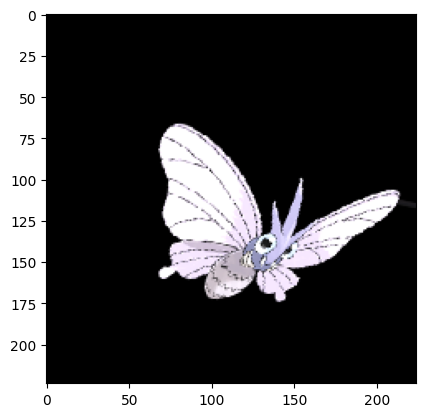

In [3]:
import matplotlib.pyplot as plt
x_batch, y_batch = next(iter(train_gen))
print("x_batch:", x_batch.shape, "dtype:", x_batch.dtype)
print("min:", x_batch.min(), "max:", x_batch.max())

plt.imshow(x_batch[2].astype("uint8") )
plt.show()


In [4]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# defining the model based on the base model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision,Recall, AUC
from tensorflow.keras.regularizers import l2

# freeze the base
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(18, activation='sigmoid', kernel_regularizer=l2(1e-4))  # 18 is the number of pokemon types so 18 classes
])

model.compile(
    optimizer=Adam(1e-3),
    loss=BinaryCrossentropy(),
    metrics=[AUC(name='auc', multi_label=True), Precision(name='precision'), Recall(name='recall')]

)
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 18)                23058     
                                                                 
Total params: 4072629 (15.54 MB)
Trainable params: 23058 (90.07 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [5]:
from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,  
    callbacks=[EarlyStopping(
        monitor='val_auc',
        patience=5,
        restore_best_weights=True
    )]
)

Epoch 1/20

46/46 [==============================] - 24s 417ms/step - loss: 0.3682 - auc: 0.4989 - precision: 0.1036 - recall: 0.0648 - val_loss: 0.3093 - val_auc: 0.5591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
46/46 [==============================] - 17s 374ms/step - loss: 0.2884 - auc: 0.5944 - precision: 0.5789 - recall: 0.0102 - val_loss: 0.2966 - val_auc: 0.6049 - val_precision: 0.5000 - val_recall: 0.0023
Epoch 3/20
46/46 [==============================] - 17s 360ms/step - loss: 0.2758 - auc: 0.6455 - precision: 0.5319 - recall: 0.0231 - val_loss: 0.2927 - val_auc: 0.6306 - val_precision: 0.5000 - val_recall: 0.0023
Epoch 4/20
46/46 [==============================] - 17s 358ms/step - loss: 0.2617 - auc: 0.7068 - precision: 0.6286 - recall: 0.0407 - val_loss: 0.2903 - val_auc: 0.6545 - val_precision: 0.2857 - val_recall: 0.0045
Epoch 5/20
46/46 [==============================] - 17s 370ms/step - loss: 0.2533 - auc: 0.7399 - precision: 0.6386 - recall: 0.049

46/46 - 12s - loss: 0.1849 - auc: 0.9094 - precision: 0.9102 - recall: 0.2065 - 12s/epoch - 255ms/step
[0.18490253388881683, 0.9093743562698364, 0.9102040529251099, 0.20648148655891418]
18/18 - 3s - loss: 0.2847 - auc: 0.7160 - precision: 0.5000 - recall: 0.0341 - 3s/epoch - 154ms/step
[0.2846667468547821, 0.7160203456878662, 0.5, 0.034090910106897354]


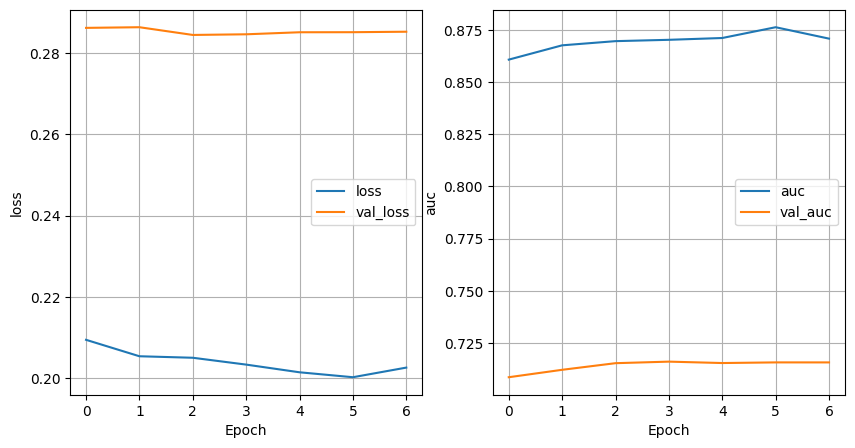

In [10]:
h = history_finetune
keys = list(h.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(h.history[keys[idx]], label=keys[idx])
    axes[idx].plot(h.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

# print( model.evaluate(full_gen, verbose=2)); 
print( model.evaluate(train_gen, verbose=2)); 
print( model.evaluate(valid_gen, verbose=2)); 
# print("\n\nLoss on test set {:.3},  Categorical accuracy on test set {:.3f}, AUC {:.3f}".format(test_loss, test_acc, auc))

In [ ]:

model.save('../models/poke_efficnet(0.698auc).h5')
print("✅ Model saved")

In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model("../models/poke_efficnet_(224,0.74auc).h5", compile=False)  # load weights

In [8]:

# 1. Unfreeze last ~30 layers of the base EfficientNet
# (assuming your model = Sequential([base_model, ...]))
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if "block6" in layer.name or "block7" in layer.name:  # last 2 blocks
        set_trainable = True
    if set_trainable:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
    else:
        layer.trainable = False

# 2. Recompile with a much smaller LR
model.compile(
    optimizer=Adam(1e-5),   # smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=[AUC(name='auc', multi_label=True), Precision(name='precision'), Recall(name='recall')]
)


In [9]:
from tensorflow.keras.callbacks import  ReduceLROnPlateau
# 3. Set callbacks
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.2,
    patience=2,
    min_lr=1e-7
)

# 4. Train for a smaller number of epochs (since we’re fine-tuning)
history_finetune = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
46/46 [==============================] - 29s 466ms/step - loss: 0.2094 - auc: 0.8608 - precision: 0.7338 - recall: 0.1889 - val_loss: 0.2862 - val_auc: 0.7085 - val_precision: 0.6000 - val_recall: 0.0273 - lr: 1.0000e-05
Epoch 2/10
46/46 [==============================] - 20s 428ms/step - loss: 0.2054 - auc: 0.8677 - precision: 0.7285 - recall: 0.1963 - val_loss: 0.2864 - val_auc: 0.7121 - val_precision: 0.6000 - val_recall: 0.0341 - lr: 1.0000e-05
Epoch 3/10
46/46 [==============================] - 17s 361ms/step - loss: 0.2050 - auc: 0.8697 - precision: 0.7222 - recall: 0.2046 - val_loss: 0.2845 - val_auc: 0.7153 - val_precision: 0.5161 - val_recall: 0.0364 - lr: 1.0000e-05
Epoch 4/10
46/46 [==============================] - 19s 408ms/step - loss: 0.2033 - auc: 0.8703 - precision: 0.7606 - recall: 0.2324 - val_loss: 0.2847 - val_auc: 0.7160 - val_precision: 0.5000 - val_recall: 0.0341 - lr: 2.0000e-06
Epoch 5/10
46/46 [==============================] - 19s 412ms/step - los